In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

from gwas_tools import read_bed, write_bed, nancorr
from scipy.stats.stats import pearsonr

# download & install prerequisites

# 1. download files from https://github.com/comorment/containers/tree/main/reference/hapgen
for file_ext in ['bed', 'bim', 'fam']:
    if not os.path.exists(f'chr21.{file_ext}'):
        url = 'https://media.githubusercontent.com/media/comorment/containers/main/reference/hapgen/chr21'
        os.system(f'wget {url}.{file_ext}')

# 2. install plink 2 (choose mac version if you're on M1 chip laptop)
# see here https://www.cog-genomics.org/plink/2.0/ for latest plink version
if not os.path.exists('plink2'):
    #fname = 'plink2_mac_arm64_20231123.zip'
    fname = 'plink2_linux_x86_64_20231123.zip'
    os.system(f'wget https://s3.amazonaws.com/plink2-assets/{fname}')
    os.system(f'unzip {fname}')

# 3. install simu_linux
if not os.path.exists('simu_linux'):
    os.system('wget https://github.com/precimed/simu/releases/download/v0.9.4/simu_linux')
    os.system('chmod a+x simu_linux')
    
# 4. install prsice2
if not os.path.exists('PRSice_linux'):
    os.system('wget https://github.com/choishingwan/PRSice/releases/download/2.3.5/PRSice_linux.zip')
    os.system('unzip PRSice_linux.zip')

In [5]:
os.system('plink2 --bfile chr21 --chr 21 --from-kb 32000 --to-kb 34000 --make-bed --out chr21_chunk')
geno_bin = read_bed('chr21_chunk')
geno = geno_bin.T.copy().astype(np.float32)


PLINK v2.00a3.7 64-bit (24 Oct 2022)           www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to chr21_chunk.log.
Options in effect:
  --bfile chr21
  --chr 21
  --from-kb 32000
  --make-bed
  --out chr21_chunk
  --to-kb 34000

Start time: Tue Dec  5 12:02:27 2023
16384 MiB RAM detected; reserving 8192 MiB for main workspace.
Using up to 8 compute threads.
10000 samples (0 females, 0 males, 10000 ambiguous; 10000 founders) loaded from
chr21.fam.
149454 variants loaded from chr21.bim.
1 binary phenotype loaded (0 cases, 10000 controls).
8275 variants remaining after main filters.
Writing chr21_chunk.fam ... done.
Writing chr21_chunk.bim ... done.
Writing chr21_chunk.bed ... 0%done.
End time: Tue Dec  5 12:02:27 2023
    8275 SNPs
    10000 samples


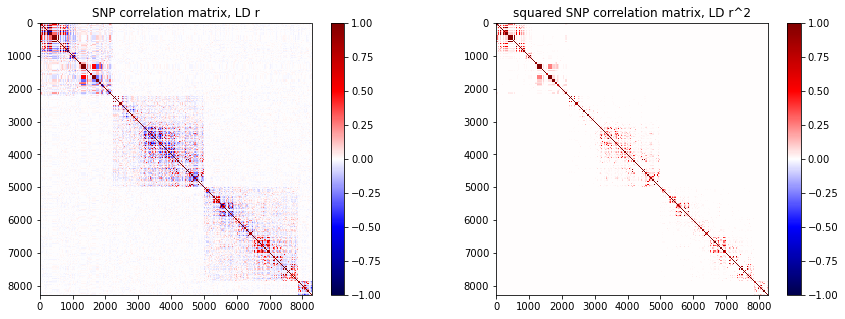

<Figure size 432x288 with 0 Axes>

In [6]:
# illustraiton of the LD matrix
# - use 'plink2' to constrain genotypes to a subset of SNPs from chr21:32-34 MB region
# - load those SNPs into python as a genotype matrix
# - compute SNP correlations (known as 'linkage disequilibrium matrix, or LD matrix')
# - visualize LD matrix

#ld, _, _ = nancorr(geno, geno)  # snp correlatino matrix
ld = np.corrcoef(geno.T)
ld_r2 = np.multiply(ld, ld)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(ld, vmin=-1, vmax=1, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.title('SNP correlation matrix, LD r')

plt.subplot(1,2,2)
plt.imshow(ld_r2, vmin=-1, vmax=1, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.title('squared SNP correlation matrix, LD r^2')

plt.show()
plt.savefig('ld_matrix.png');

In [7]:
# generate phenotype and GWAS summary statistics, using 9000 out of 10000 subjects available
# visualize the results as Q-Q and manhattan plots

def generate_sumstats(out_prefix='simu'):
    trait='1'
    assert 0==os.system(f'simu_linux --bfile chr21 --qt --causal-pi 0.001 --hsq 0.10 --seed 1676022526 --out {out_prefix}  >nul 2>nul')
    assert 0==os.system(f'head -n 9000 chr21.fam > chr21_9k.fam')
    assert 0==os.system(f'plink2 --keep chr21_9k.fam --glm --bfile chr21 --pheno {out_prefix}.pheno --out {out_prefix}  >nul 2>nul')

    df=pd.read_csv(f'{out_prefix}.trait{trait}.glm.linear', delim_whitespace=True)
    df['A2'] = df['REF']; idx=df['A2']==df['A1']; df.loc[idx, 'A2']=df.loc[idx, 'ALT']; del df['REF']; del df['ALT']; del df['TEST']
    assert not df.isnull().any(axis=None); # df.dropna(inplace=True);
    df.rename(columns={'ID':'SNP', '#CHROM':'CHR', 'POS':'BP', 'OBS_CT':'N', 'T_STAT':'Z', 'A1_FREQ':'FRQ'}, inplace=True)
    df[sorted(df.columns)].to_csv(f'{out_prefix}.sumstats.gz', sep='\t', index=False)
    return df

df = generate_sumstats(out_prefix='simu')    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(-np.log10(np.array(range(1,1+len(df)))/len(df)),    
        -np.log10(sorted(df['P'].values)))
plt.plot([0, 5], [0, 5], 'k--')
plt.title('Q-Q plot', fontsize=16);
plt.xlabel('log10(p-value), expected under null', fontsize=16);
plt.ylabel('log10(p-value), actual', fontsize=16);

plt.subplot(1,3,2)
plt.plot(df['BP'].values / 1e6, -np.log10(df['P'].values))
plt.title('Manhattan plot', fontsize=16);
plt.ylabel('-log10(p-value)', fontsize=16);
plt.xlabel('chr21, position in MB', fontsize=16);
plt.savefig('qq_manh.png')

plt.subplot(1,3,3)
plt.hist(df['P'].values, bins=20)
plt.title('p-value, histogram');

AssertionError: 

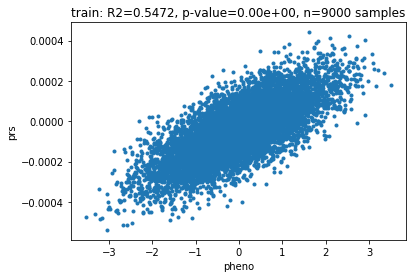

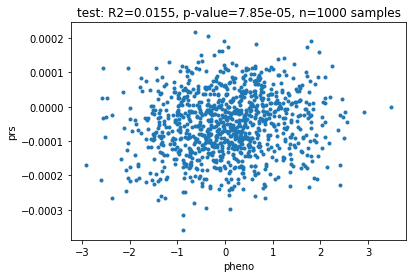

In [11]:
# for a technical reason, select first 1000 subjects whihc will be used as --ld argument of PRSice_linux
# note that this is NOT related to train/test split of the data into 9000 (train) vs 1000 (test)
os.system('head -n 1000 chr21.fam > chr21_1k.fam')
os.system('plink2 --bfile chr21 --keep chr21_1k.fam --make-bed --out chr21_1k')

# perform polygenic risk scoring analysis. PRS will be calculated for the entire sample.
# for further infor on PRSice_linux, see https://choishingwan.github.io/PRSice/
os.system('./PRSice_linux --base simu.sumstats.gz --binary-target F --pheno simu.pheno --pheno-col '
          'trait1 --target chr21 --type bed --ld chr21_1k --ld-type bed '
          '--bar-levels 5e-8,1e-6,1e-5,1e-4,1e-3,1e-2,0.05,0.1,0.5,1.0 --fastscore --no-full --out prs')

# train is very much overfitted
# test is giving R2 that is several times lower than --hsq argument of the simu_linux call
for train_test in ['train', 'test']:
    plt.figure()
    gwas_fam = pd.read_csv('chr21_9k.fam', delim_whitespace=True, header=None)
    prs = pd.read_csv('prs.best',delim_whitespace=True)
    pheno = pd.read_csv('simu.pheno', sep='\t')

    if train_test == 'train':
        prs=prs[prs['IID'].isin(gwas_fam[1].values)].copy()
        pheno=pheno[pheno['IID'].isin(gwas_fam[1].values)].copy()
    else:
        prs=prs[~prs['IID'].isin(gwas_fam[1].values)].copy()
        pheno=pheno[~pheno['IID'].isin(gwas_fam[1].values)].copy()

    plt.plot(pheno['trait1'].values, prs['PRS'].values, '.')
    r, r_pval = pearsonr(pheno['trait1'].values, prs['PRS'].values)
    plt.title(f'{train_test}: R2={(r*r):.4f}, p-value={r_pval:.2e}, n={len(prs)} samples')
    plt.xlabel('pheno')
    plt.ylabel('prs')


In [44]:
geno = geno.T.copy()


In [43]:
geno.dtype

dtype('float32')

In [45]:
geno.shape

(10000, 149454)

In [46]:
geno_1k = geno[:, :1000].copy()

In [48]:
tic = time.time()
r,t,n = nancorr(geno_1k, geno_1k)
toc = time.time()
print(toc-tic, 'sec Elapsed')


0.7010807991027832 sec Elapsed


In [49]:
r.shape

(1000, 1000)

In [50]:
r[:5, :5
]

array([[ 0.99999994, -0.35374242,  0.99902445, -0.52384084, -0.49255946],
       [-0.35374248,  1.        , -0.35227144, -0.6111067 , -0.58981717],
       [ 0.99902445, -0.35227144,  1.        , -0.5243547 , -0.49310514],
       [-0.5238408 , -0.6111067 , -0.5243546 ,  1.0000001 ,  0.95395464],
       [-0.49255946, -0.58981717, -0.49310523,  0.95395464,  0.9999999 ]],
      dtype=float32)

In [20]:
def get_byte_geno_map():
    """
    Construct mapping between bytes 0..255 and 4-element arrays of a1 genotypes
    from plink bed file.
    Return 256 x 4 array A, where A[i] = [a1, a2, a3, a4], each ai from {2, -1, 1, 0}.
    """
    genotype_codes = np.array([2, -1, 1, 0],dtype=np.int8)
    byte_map = np.empty((256,4), dtype=np.int8)
    for b in range(256):
        for a in range(4):
            byte_map[b,a] = genotype_codes[(b >> 2*a) & 3]
    return byte_map

g=get_byte_geno_map()
g=g[:,0]
np.array([g[[1,2,3,4,5]], g[[1,2,3,4,5]], g[[1,2,3,4,5]], g[[1,2,3,4,5]]])

array([[-1,  1,  0,  2, -1],
       [-1,  1,  0,  2, -1],
       [-1,  1,  0,  2, -1],
       [-1,  1,  0,  2, -1]], dtype=int8)